##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DeepDream

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/deepdream"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial contains a minimal implementation of DeepDream, as described in this [blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) by Alexander Mordvintsev.

DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

It does so by forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. This process was dubbed "Inceptionism" (a reference to [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf), and the [movie](https://en.wikipedia.org/wiki/Inception) Inception).

Let's demonstrate how you can make a neural network "dream" and enhance the surreal patterns it sees in an image.

![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

In [3]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

## Choose an image to dream-ify

For this tutorial, let's use an image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg).

In [4]:
from PIL import Image

#original_img = Image.open(r"photo.jpg")
#show(original_img)

90112/83281 [================================] - 0s 0us/step


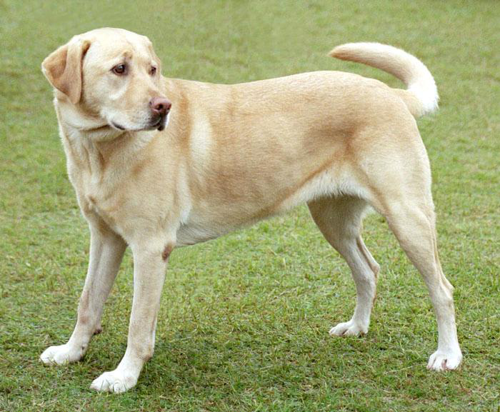

In [5]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):  #conver [-1,1] to [0,255]
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

## Prepare the feature extraction model

Download and prepare a pre-trained image classification model. You will use [InceptionV3](https://keras.io/applications/#inceptionv3) which is similar to the model originally used in DeepDream. Note that any [pre-trained model](https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet) will work, although you will have to adjust the layer names below if you change this.

In [6]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [7]:
#IncepV3_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
#dot_img_file = '/InceptionV3.png'
#tf.keras.utils.plot_model(IncepV3_model, to_file=dot_img_file, show_shapes=True)
#img = PIL.Image.open(dot_img_file)
#display.display(PIL.Image.fromarray(np.array(img)))

The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.

The InceptionV3 architecture is quite large (for a graph of the model architecture see TensorFlow's [research repo](https://github.com/tensorflow/models/tree/master/research/inception)). For DeepDream, the layers of  interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper.

In [8]:
#dot_img_file = '/model_base.png'
#tf.keras.utils.plot_model(base_model, to_file=dot_img_file, show_shapes=True)
#img = PIL.Image.open(dot_img_file)
#display.display(PIL.Image.fromarray(np.array(img)))

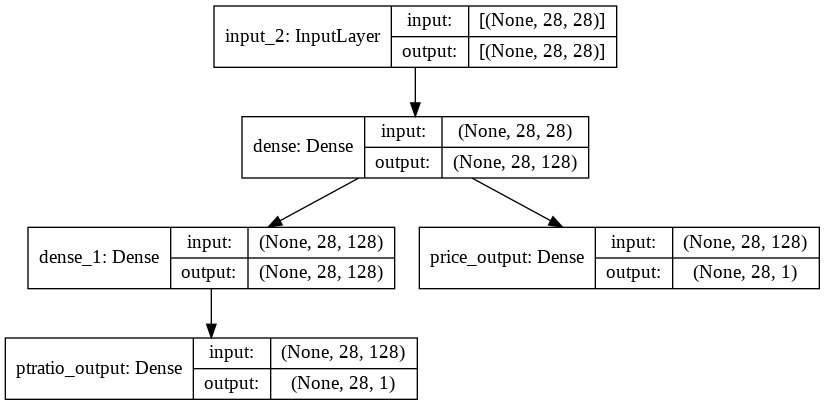

In [9]:
from tensorflow import keras
def build_model():
    # Define model layers.
    input_layer = keras.layers.Input(shape=[28,28])
    first_dense = keras.layers.Dense(units='128', activation='relu')(input_layer)
    # Y1 output will be fed from the first dense
    y1_output = keras.layers.Dense(units='1', name='price_output')(first_dense)
    second_dense = keras.layers.Dense(units='128',activation='relu')(first_dense)
    # Y2 output will be fed from the second dense
    y2_output = keras.layers.Dense(units='1',name='ptratio_output')(second_dense)
    # Define the model with the input layer 
    # and a list of output layers
    model = keras.Model(inputs=input_layer,outputs=[y1_output, y2_output])
    return model

model_test = build_model()

tf.keras.utils.plot_model(model_test, show_shapes=True)


In [10]:
# Maximize the activations of these layers
names = ['mixed6']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [11]:
#from PIL import Image

#dot_img_file = '/model_only_mix3.png'
#tf.keras.utils.plot_model(dream_model, to_file=dot_img_file, show_shapes=True)
#img = PIL.Image.open(dot_img_file)
#display.display(PIL.Image.fromarray(np.array(img)))

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [12]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. See the [Concrete functions guide](../../guide/concrete_function.ipynb) for details.

In [26]:
# calculate loss from a specific layer
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0) #增加demention, 因为只输入了一个图片所以是3维，but the model requires 4-d

  layer_activations = model(img_batch) # check ouput

  #tf.print("layer_activations: ",layer_activations.shape)
  
  if len(layer_activations) == 1:   #'outputs' only contains one mix layer? covert to a list
    layer_activations = [layer_activations]

   
  tol_losses = []
  for act in layer_activations:

    #tf.print("act: ",act.shape)
    channel = act[0, :, :, 0]   #  channel number

    layer_loss = tf.math.reduce_mean(act)  # the whole layer activation
    channel_loss = tf.math.reduce_mean(channel)  # the specific channel activation

    tol_losses.append(channel_loss) 
  return  tf.reduce_sum(tol_losses)



class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32), #image size is unknown
        tf.TensorSpec(shape=[], dtype=tf.int32),    # steps
        tf.TensorSpec(shape=[], dtype=tf.float32),)  # step_size
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")

      loss = tf.constant(0.0)

      scale_tv = tf.constant(1e-4)
      
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = tf.negative(calc_loss(img, self.model))  #______________________________________________ tf.negative

          tf.print("loss: ",loss)

          tv = tf.image.total_variation(img) # total variance loss
          scale_tv = tf.cast(scale_tv, tv.dtype)
          total_reg = tf.scalar_mul(scale_tv,tv) #+ tf.reduce_sum(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES))#basic L2 loss
          loss = loss + total_reg   #4-D Tensor of shape [batch, height, width, channels] or 3-D Tensor of shape [height, width, channels].
         # tf.print("total_regularization: ",total_reg)
          

    
        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

    #    opt.apply_gradients(zip([gradients], [img]))
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img - gradients*step_size
        # returns a tensor of the same type and shape as t with its values clipped to clip_value_min and clip_value_max
        img = tf.clip_by_value(img, -1, 1)  

      return loss, img

In [27]:
deepdream = DeepDream(dream_model)

## Main Loop

In [28]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)


  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:  # run 100 steps each time
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))  #img [height,width,channel]
    
    #display.clear_output(wait=True) # wait --> Wait to clear the output until new output is available to replace it.
    show(deprocess(img))  # img 没变，因为没赋值
    print ("Step {}, loss {}".format(step, loss))

  #show the final result
  result = deprocess(img)
  #display.clear_output(wait=True)
  show(result)

  return result

<class 'numpy.ndarray'>


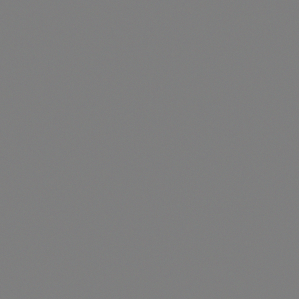


Tracing
loss:  -0.656167
loss:  -0.428505868
loss:  -0.844192445
loss:  -1.27274942
loss:  -1.7412101
loss:  -2.13684
loss:  -2.51361203
loss:  -2.83109498
loss:  -3.24685478
loss:  -3.50464153
loss:  -3.77567697
loss:  -3.98898625
loss:  -4.25607204
loss:  -4.45114136
loss:  -4.70065165
loss:  -4.87876
loss:  -5.12054348
loss:  -5.22916126
loss:  -5.32808924
loss:  -5.55114079
loss:  -5.74796772
loss:  -5.84140348
loss:  -6.05071497
loss:  -6.15153837
loss:  -6.3257432
loss:  -6.44194555
loss:  -6.46578026
loss:  -6.67775869
loss:  -6.68858862
loss:  -6.94285297
loss:  -6.96297073
loss:  -7.14335966
loss:  -7.22205544
loss:  -7.39542913
loss:  -7.41325808
loss:  -7.58382702
loss:  -7.63515568
loss:  -7.82770252
loss:  -7.85371065
loss:  -7.99086714
loss:  -7.96985149
loss:  -8.15308
loss:  -8.18303108
loss:  -8.28826332
loss:  -8.40373421
loss:  -8.35042667
loss:  -8.51094246
loss:  -8.49675274
loss:  -8.68883324
loss:  -8.7107954
loss:  -8.75422096
loss:  -8.76640511
loss:  -8.90764

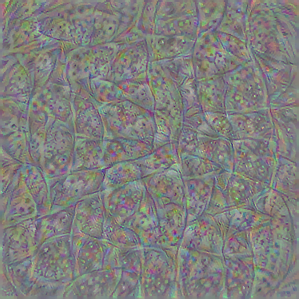

Step 100, loss -7.3216047286987305
loss:  -10.613699
loss:  -10.6346025
loss:  -10.6618309
loss:  -10.6987848
loss:  -10.6306343
loss:  -10.7496881
loss:  -10.707634
loss:  -10.7013655
loss:  -10.7592859
loss:  -10.7663755
loss:  -10.7955761
loss:  -10.7701569
loss:  -10.8815079
loss:  -10.829648
loss:  -10.8952379
loss:  -10.8762274
loss:  -10.9375544
loss:  -10.8578205
loss:  -10.9979506
loss:  -10.8596725
loss:  -11.0092974
loss:  -10.9054575
loss:  -11.0439434
loss:  -10.9844885
loss:  -11.0770264
loss:  -11.0154333
loss:  -11.1343193
loss:  -11.0677319
loss:  -11.1710978
loss:  -11.1051664
loss:  -11.2551308
loss:  -11.1686506
loss:  -11.2189293
loss:  -11.1876898
loss:  -11.2784
loss:  -11.2805758
loss:  -11.3224478
loss:  -11.2939568
loss:  -11.365922
loss:  -11.3004084
loss:  -11.4249611
loss:  -11.347621
loss:  -11.3838673
loss:  -11.4268551
loss:  -11.3515568
loss:  -11.429306
loss:  -11.4375706
loss:  -11.4222412
loss:  -11.466815
loss:  -11.4586926
loss:  -11.4318762
loss: 

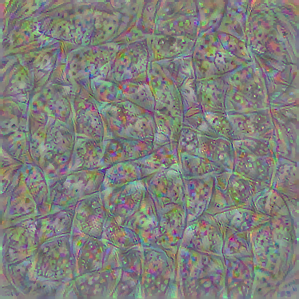

Step 200, loss -8.331330299377441
loss:  -12.1654234
loss:  -11.9946136
loss:  -12.1206026
loss:  -12.057539
loss:  -12.1400938
loss:  -12.0284615
loss:  -12.0941973
loss:  -12.1018076
loss:  -12.1646891
loss:  -12.1076584
loss:  -12.2853317
loss:  -12.0862
loss:  -12.176136
loss:  -12.0866108
loss:  -12.2061806
loss:  -12.1076851
loss:  -12.2620239
loss:  -12.1838417
loss:  -12.2984056
loss:  -12.1785183
loss:  -12.3030806
loss:  -12.2629347
loss:  -12.3252211
loss:  -12.2477856
loss:  -12.3237333
loss:  -12.2260513
loss:  -12.349577
loss:  -12.2488346
loss:  -12.3058319
loss:  -12.2283878
loss:  -12.3196173
loss:  -12.2681141
loss:  -12.3633146
loss:  -12.350647
loss:  -12.4189148
loss:  -12.4004335
loss:  -12.4764528
loss:  -12.3590679
loss:  -12.4489985
loss:  -12.4271173
loss:  -12.462451
loss:  -12.4326429
loss:  -12.5399094
loss:  -12.4247456
loss:  -12.5673685
loss:  -12.4857702
loss:  -12.5343027
loss:  -12.5184746
loss:  -12.4800005
loss:  -12.501009
loss:  -12.4189978
loss: 

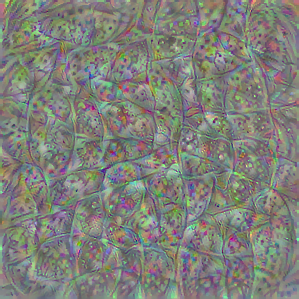

Step 300, loss -9.006638526916504
loss:  -12.7414713
loss:  -12.8723907
loss:  -12.8282413
loss:  -12.7881765
loss:  -12.8570442
loss:  -12.9227018
loss:  -12.8134947
loss:  -12.9184961
loss:  -12.8018169
loss:  -12.911972
loss:  -12.8050241
loss:  -12.9556818
loss:  -12.8484116
loss:  -12.9356165
loss:  -12.9160929
loss:  -12.9378176
loss:  -12.9555187
loss:  -12.9377899
loss:  -12.8988037
loss:  -12.9191046
loss:  -12.9142447
loss:  -12.9281197
loss:  -12.998848
loss:  -12.9004993
loss:  -13.0113373
loss:  -12.9214706
loss:  -13.0216312
loss:  -12.8947964
loss:  -13.0296926
loss:  -12.9166317
loss:  -12.9725094
loss:  -12.920332
loss:  -12.9582481
loss:  -12.9458847
loss:  -12.9890099
loss:  -12.9387169
loss:  -13.1004486
loss:  -12.950532
loss:  -13.0319366
loss:  -12.9590569
loss:  -13.1006012
loss:  -12.9671974
loss:  -13.1605129
loss:  -13.0159111
loss:  -13.1470947
loss:  -13.0522137
loss:  -13.1234083
loss:  -13.0264616
loss:  -13.139802
loss:  -13.0099106
loss:  -13.1526928
lo

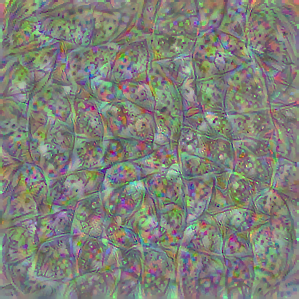

Step 400, loss -9.234830856323242
loss:  -13.261879
loss:  -13.3646278
loss:  -13.2548857
loss:  -13.3217201
loss:  -13.3085909
loss:  -13.3715048
loss:  -13.3006525
loss:  -13.3773537
loss:  -13.2193432
loss:  -13.3712063
loss:  -13.2387629
loss:  -13.4121351
loss:  -13.2285976
loss:  -13.4186535
loss:  -13.3086863
loss:  -13.3905268
loss:  -13.3585606
loss:  -13.4574928
loss:  -13.3765736
loss:  -13.4456635
loss:  -13.4083252
loss:  -13.4300098
loss:  -13.3960381
loss:  -13.4521103
loss:  -13.4091387
loss:  -13.4818583
loss:  -13.377985
loss:  -13.3932209
loss:  -13.4441404
loss:  -13.4004259
loss:  -13.4896126
loss:  -13.4212742
loss:  -13.4905052
loss:  -13.3953276
loss:  -13.5390425
loss:  -13.3385181
loss:  -13.524416
loss:  -13.324976
loss:  -13.4826994
loss:  -13.3730803
loss:  -13.5245667
loss:  -13.2894344
loss:  -13.550663
loss:  -13.3931665
loss:  -13.5083561
loss:  -13.3608885
loss:  -13.5572929
loss:  -13.3875437
loss:  -13.5065756
loss:  -13.4014521
loss:  -13.5916338
lo

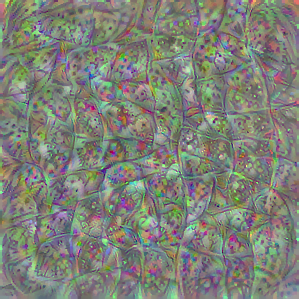

Step 500, loss -9.379400253295898


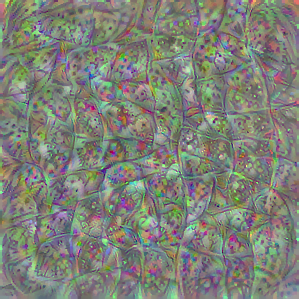

In [29]:
print(type(original_img))
#print(original_img.shape)  # original_img (RGB) [0-255]



noise = tf.random.normal(shape=[299,299,3],stddev = 0.01,dtype=tf.dtypes.float32)  #tensor
#print(tf.image.per_image_standardization(noise))
noise = deprocess(noise)
noise = noise.numpy()
show(noise)
print()

dream_img = run_deep_dream_simple(img=noise, 
                                  steps=500, step_size=0.02)

## Taking it up an octave

Pretty good, but there are a few issues with this first attempt: 

  1. The output is noisy (this could be addressed with a `tf.image.total_variation` loss).
  1. The image is low resolution.
  1. The patterns appear like they're all happening at the same granularity.
  
One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves.


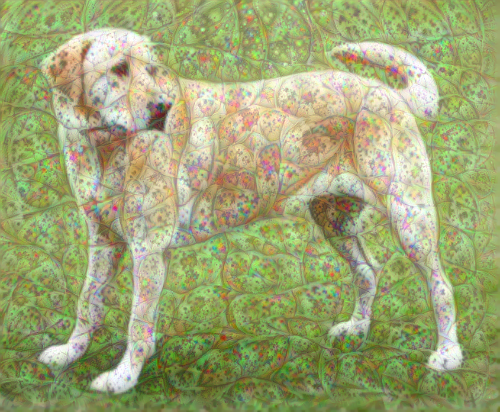

13.80038571357727

In [17]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = original_img
#img = tf.constant(np.array(noise))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## Optional: Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

Start by implementing the random shift:

In [18]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

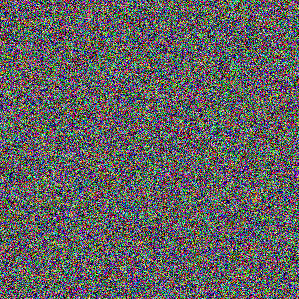

In [19]:
shift, img_rolled = random_roll(np.array(noise), 512) #
show(img_rolled)

Here is a tiled equivalent of the `deepdream` function defined earlier:

In [20]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):                      #512
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [21]:
get_tiled_gradients = TiledGradients(dream_model)

Putting this together gives a scalable, octave-aware deepdream implementation:

In [22]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):  #1.3
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

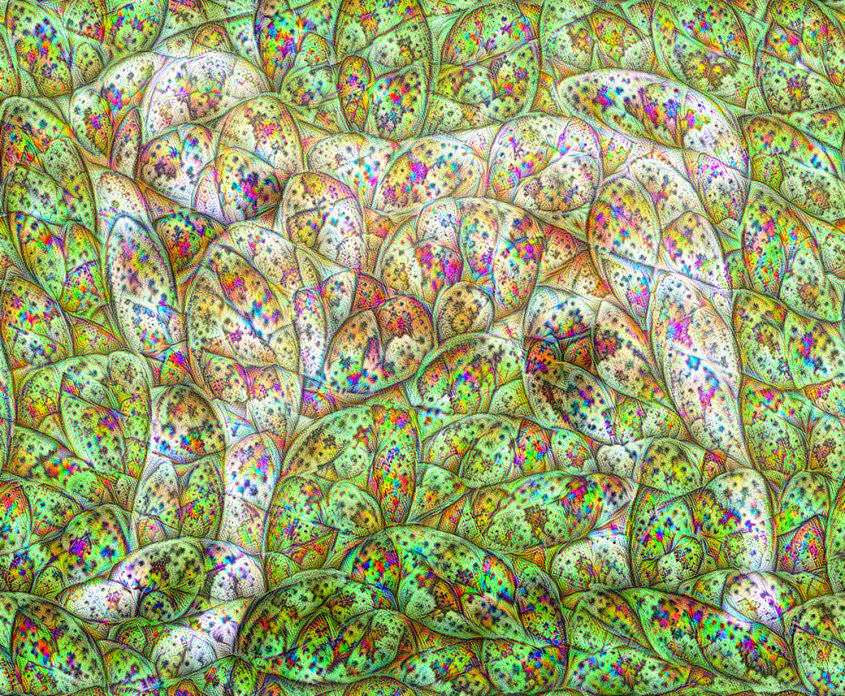

Octave 2, Step 90


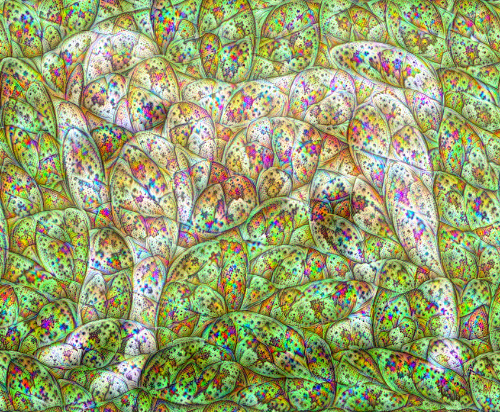

In [23]:
img = run_deep_dream_with_octaves(img=original_img, steps_per_octave=100,step_size=0.02)

#display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

Much better! Play around with the number of octaves, octave scale, and activated layers to change how your DeepDream-ed image looks.

Readers might also be interested in [TensorFlow Lucid](https://github.com/tensorflow/lucid) which expands on ideas introduced in this tutorial to visualize and interpret neural networks.